In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

from got10k.trackers import Tracker
from got10k.experiments import ExperimentGOT10k
from utils import scores
from utils import plotting
from IPython import display

import shutil
%matplotlib inline

In [7]:
model_path = "./pysot/models/rpn_res50.pth"
### СКАЧАТЬ МОДЕЛЬ
### 'https://drive.google.com/file/d/1-tEtYQdT1G9kn8HsqKNDHVqjE16F8YQH/view?usp=drive_link'
### Поместить и переименовать в соответствии с model_path

if (not os.path.exists(model_path)):
    import requests
    url = 'https://drive.google.com/u/0/uc?id=1-tEtYQdT1G9kn8HsqKNDHVqjE16F8YQH&export=download&confirm=t&uuid=afd42841-2c3c-42a6-80eb-bef8b5157555&at=AB6BwCCrpEW_LEhqItrzgSkQn8S3:1698336708620'
    r = requests.get(url, allow_redirects=True)

    open(model_path, 'wb').write(r.content)

In [8]:
def return_tracker(local_config):
    cfg.merge_from_file(local_config["config"])
    cfg.CUDA = torch.cuda.is_available() and cfg.CUDA
    device = torch.device('cuda' if cfg.CUDA else 'cpu')

    model = ModelBuilder()
    model.load_state_dict(torch.load(local_config["model"],
        map_location=lambda storage, loc: storage.cpu()))
    model.eval().to(device)

    return build_tracker(model)

In [9]:
class IdentityTracker(Tracker):
    def __init__(self, tracker_config, model_name):
        super(IdentityTracker, self).__init__(
            name=model_name, 
            is_deterministic=True   
        )
        self.tracker = return_tracker(tracker_config)
    
    def init(self, image, box):
        self.box = box
        open_cv_image = np.array(image) 
        self.tracker.init(open_cv_image, box)

    def update(self, image):
        open_cv_image = np.array(image) 
        outputs = self.tracker.track(open_cv_image)
        return np.array(outputs['bbox'], dtype=np.int64)

In [10]:
data_path1 = "./datasets/GOT/val/GOT-10k_Val_000006" # Машина classes = 2
data_path2 = "./datasets/GOT/val/GOT-10k_Val_000055" # Объект сразу пропадает. classes = 1
data_path3 = "./datasets/GOT/val/GOT-10k_Val_000147" # classes = 21

data_path = data_path2
last_val_dir = data_path.split("/")[-1] 

In [11]:
## ДАЛЕЕ ЕСТЬ ТРЕБУЕТСЯ ЗАПУСТИТЬ ТЕСТ ТОЛЬКО ДЛЯ ОДНОЙ ВЫБОРКИ или ее изменить, ТО НУЖНО:
## datasets/GOT/vallist.txt добавить / удалить NAME_DIR тестовой выборки
f = open("./datasets/GOT/val/list.txt", "w")
f.write(last_val_dir)
f.close()

In [12]:
TRACK_CONFIG = {
    "config": "./pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml",
    "model": "./pysot/models/rpn_res50.pth"
}
model_name = "SiameseRPN++"
tracker = IdentityTracker(TRACK_CONFIG, model_name)
experiment = ExperimentGOT10k(
        root_dir="../Mot/datasets/GOT",  # GOT-10k's root directory
        subset='val',                    # 'train' | 'val' | 'test'
        result_dir='sot_tracking_results',       # where to store tracking results
        report_dir='reports'        # where to store evaluation reports
    )

Running tracker SiameseRPN++ on GOT-10k...
--Sequence 1/1: GOT-10k_Val_000055
 Repetition: 1
  Results recorded at sot_tracking_results\GOT-10k\SiameseRPN++\GOT-10k_Val_000055\GOT-10k_Val_000055_001.txt
Evaluating SiameseRPN++
Saving success plots to reports\GOT-10k\SiameseRPN++\success_plot.png


{'SiameseRPN++': {'overall': {'ao': 0.29493069669067046,
   'sr': 0.2,
   'speed_fps': 17.20762817821677,
   'succ_curve': [0.9857142857142858,
    0.9857142857142858,
    0.9857142857142858,
    0.9428571428571428,
    0.8,
    0.7857142857142857,
    0.7428571428571429,
    0.7285714285714285,
    0.7285714285714285,
    0.7285714285714285,
    0.7285714285714285,
    0.7142857142857143,
    0.6857142857142857,
    0.6857142857142857,
    0.6571428571428571,
    0.6571428571428571,
    0.6571428571428571,
    0.6571428571428571,
    0.6428571428571429,
    0.6285714285714286,
    0.6285714285714286,
    0.6142857142857143,
    0.6,
    0.5857142857142857,
    0.5857142857142857,
    0.5571428571428572,
    0.5571428571428572,
    0.5428571428571428,
    0.5285714285714286,
    0.5142857142857142,
    0.5,
    0.4857142857142857,
    0.4857142857142857,
    0.4857142857142857,
    0.4714285714285714,
    0.4714285714285714,
    0.45714285714285713,
    0.44285714285714284,
    0.42857

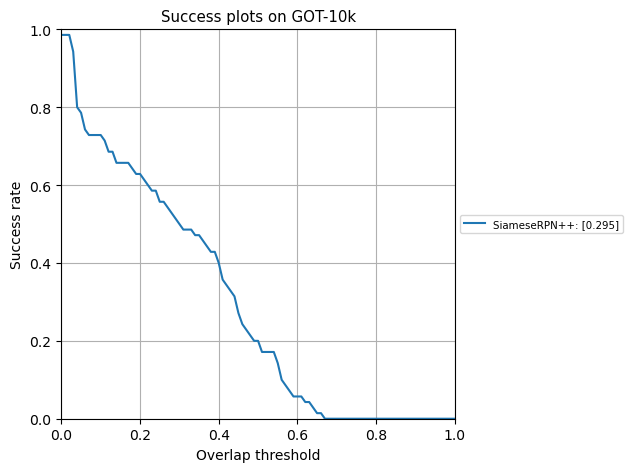

In [7]:
# Подчищаем предыдущие
RESULTS_DIR = f"./sot_tracking_results/GOT-10k/{model_name}"
REPORT_DIR = f"./reports/GOT-10k/{model_name}"
try:
    shutil.rmtree(RESULTS_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))
try:
    shutil.rmtree(REPORT_DIR)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

experiment.run(tracker, visualize=False)
experiment.report([tracker.name])

In [13]:
scores.get_scores(f"./datasets/GOT/val/{last_val_dir}/groundtruth.txt", f"sot_tracking_results/GOT-10k/SiameseRPN++/{last_val_dir}/{last_val_dir}_001.txt")

--- Evaluate for GOT-10k ---
Average Overlap (AO): 30.49 %
Success 0.5 (SR0.5): 21.13 %
Success 0.75 (SR0.75): 1.41 %
--- Evaluate for TrackingNet & LaSOT ---
Success score (AUC): 31.39 %
Precision score (P): 57.75 %
NPrecision score (P_norm): 41.43 %


In [14]:
img_names = list(filter(lambda file: file.endswith(".jpg"), os.listdir(data_path)))
img_names.sort()

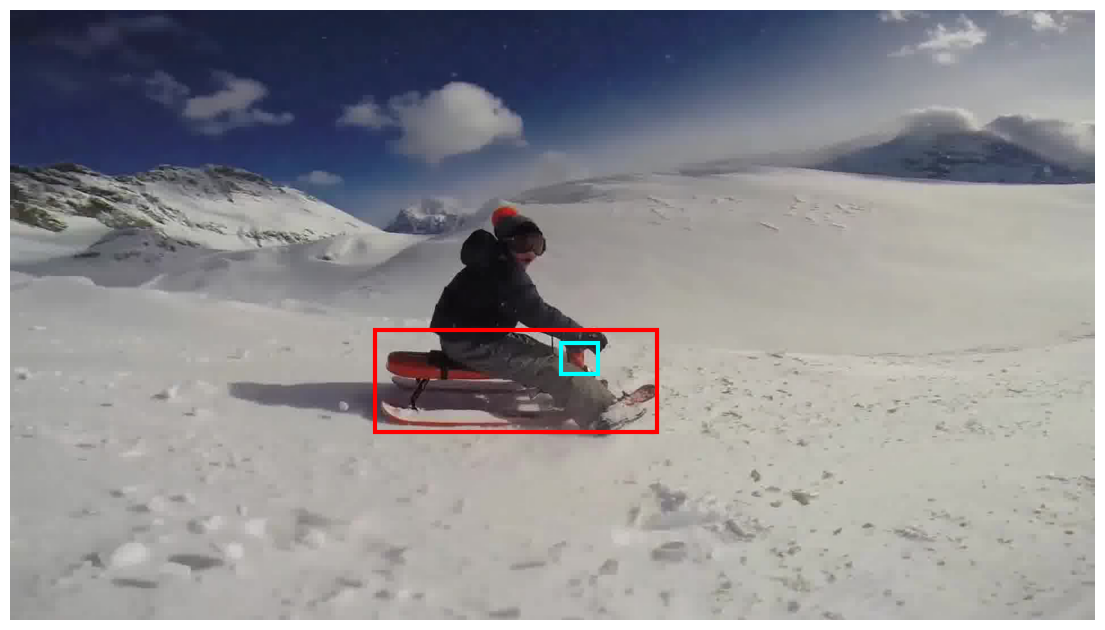

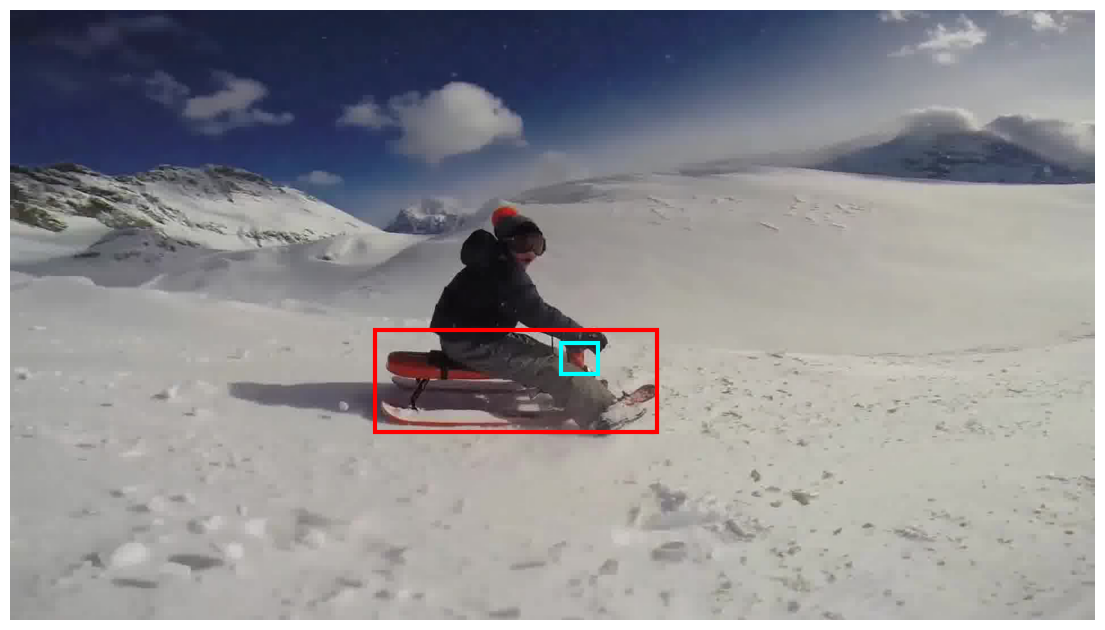

In [15]:
tracker = return_tracker(TRACK_CONFIG)
fisrt_img = True
gt_boxes = np.loadtxt(data_path + "/groundtruth.txt", delimiter=',')

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

for img_name, gt_box in zip(img_names, gt_boxes):
    img = cv2.imread(os.path.join(data_path, img_name))

    if fisrt_img:
        fisrt_img = False
        tracker.init(img, gt_box)
    else:
        outputs = tracker.track(img)
        
        ax.clear()
        display.clear_output(wait=True)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plotting.add_obj_bbox_to_plot(ax, np.array(outputs['bbox'], dtype=np.int64), plotting.COLOURS[0], centered=False)
        plotting.add_obj_bbox_to_plot(ax, np.array(gt_box, dtype=np.int64), "red", centered=False)
        ax.axis('off')
        ax.plot()
        display.display(fig)


    